In [23]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import pytz
import matplotlib.pyplot as plt

from metpy.units import units
from metpy.calc import add_height_to_pressure
from sublimpy import utils
from metpy.constants import density_water

In [24]:
import sys
sys.path.append('../splash/')
import functions_library

# SoS Run

## Load SoS Data

In [25]:
start_date = '20221130'
end_date = '20230509'
tidy_dataset_fn = f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_df = pd.read_parquet(tidy_dataset_fn)
tidy_df['time'] = pd.to_datetime(tidy_df['time'])

seconds_in_sos_timestep = 5*60

## Prep inputs for the SPLASH algorithm

In [31]:
sos_inputs_df = tidy_df[tidy_df.variable.isin(
    ['spd_3m_c', 'Tsurf_c', 'T_3m_c', 'RH_3m_c', 'mixingratio_3m_c', 'P_10m_c', 'SnowDepth_d', 'w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c', 'w_tc__3m_c']
)][['time', 'variable', 'value']].set_index('time').pivot(columns='variable')
sos_inputs_df.columns = sos_inputs_df.columns.droplevel()
# adjust pressure from 10m to 3m
sos_inputs_df['P_10m_c'] = add_height_to_pressure(
    sos_inputs_df['P_10m_c'].values * units("millibar"), 
    -7 * units("m")
)
sos_inputs_df

variable,P_10m_c,RH_3m_c,SnowDepth_d,T_3m_c,Tsurf_c,mixingratio_3m_c,spd_3m_c,w_h2o__10m_c,w_h2o__20m_c,w_h2o__3m_c,w_tc__3m_c
time,,,,,,,,,,,
2022-11-29 17:02:30,713.587475,68.460388,0.334301,-12.782964,-12.332214,0.001373,3.003085,-0.000480,-0.000448,-0.001036,-0.010002
2022-11-29 17:07:30,713.752266,70.529083,0.334301,-13.113847,-12.676758,0.001377,2.556226,-0.000525,-0.006782,-0.000371,-0.010255
2022-11-29 17:12:30,713.828676,68.807625,0.334301,-12.888330,-12.335175,0.001368,3.230316,-0.003758,-0.007581,0.000529,-0.022953
2022-11-29 17:17:30,713.878822,63.797810,0.334301,-12.585520,-12.316040,0.001300,3.807533,0.004606,0.003644,-0.001167,-0.031980
2022-11-29 17:22:30,713.836861,58.585175,0.334301,-12.469777,-12.387634,0.001204,3.765895,0.003669,0.012853,0.004871,-0.067192
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 17:37:30,719.949953,25.287973,0.398259,11.422956,0.401733,0.002961,3.554634,0.001137,-0.005230,0.007433,-0.034591
2023-05-09 17:42:30,719.927476,27.832880,0.398259,10.858793,0.294495,0.003141,3.055359,0.000798,-0.000156,-0.006595,0.011637
2023-05-09 17:47:30,719.955511,31.355602,0.398259,10.012268,-0.114899,0.003345,3.631212,0.002055,0.001738,0.010103,-0.056306


In [5]:
INVERSION_HEIGHT = 600
SOS_INSTRUMENT_HEIGHT = 3

output_var_names = [
    'hsb', 'hlb', 'tau', 'zo', 'zot', 'zoq', 'L', 'usr', 'tsr', 'qsr', 'dter', 'dqer', \
        'hl_webb', 'Cd', 'Ch', 'Ce', 'Cdn_10', 'Chn_10', 'Cen_10', 'rr', 'rt', 'rq', 
]

## Run the SPLASH algorithm

In [9]:
# INPUTS get parsed like this:
# u  = bulk_input[0] # wind speed                         (m/s)
# ts = bulk_input[1] # bulk water/ice surface tempetature (degC)
# t  = bulk_input[2] # air temperature                    (degC) 
# Q  = bulk_input[3] # air moisture mixing ratio          (kg/kg)
# zi = bulk_input[4] # inversion height                   (m)
# P  = bulk_input[5] # surface pressure                   (mb)
# zu = bulk_input[6] # height of anemometer               (m)
# zt = bulk_input[7] # height of thermometer              (m)
# zq = bulk_input[8] # height of hygrometer               (m)
sos_results_list = []
for time, row in sos_inputs_df.iterrows():
    bulk_inputs = [
        row['spd_3m_c'],
        row['Tsurf_c'],
        row['T_3m_c'],
        row['mixingratio_3m_c'],
        INVERSION_HEIGHT,
        row['P_10m_c'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        row['RH_3m_c'],
        1 # vwc "volumetric water content" doesn't matter if snow_flag = 1
    ]
    if any(pd.isnull(np.array(bulk_inputs))):
        print(f"Failed on timestamp: {time}")
        sos_results_list.append(np.full(len(output_var_names), np.nan))    
    else:
        bulk_outputs = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30')
        sos_results_list.append(bulk_outputs)
    # try:
    #     bulk_outputs = functions_library.cor_ice_A10(bulk_inputs)
    #     sos_results_list.append(bulk_outputs)
    # except:
    #     print(f"Failed on timestamp: {time}")
    #     sos_results_list.append(np.full(len(output_var_names), np.nan))

sos_results_df = pd.DataFrame(sos_results_list)
sos_results_df.columns = output_var_names
sos_results_df['time'] = sos_inputs_df.index
sos_results_df = sos_results_df.set_index('time')

Failed on timestamp: 2023-01-17 07:47:30
Failed on timestamp: 2023-01-17 07:52:30
Failed on timestamp: 2023-01-17 07:57:30
Failed on timestamp: 2023-01-17 08:02:30
Failed on timestamp: 2023-01-17 08:07:30
Failed on timestamp: 2023-01-17 08:12:30
Failed on timestamp: 2023-01-17 08:17:30
Failed on timestamp: 2023-01-17 08:22:30
Failed on timestamp: 2023-01-17 08:27:30
Failed on timestamp: 2023-01-17 08:32:30
Failed on timestamp: 2023-01-17 08:37:30
Failed on timestamp: 2023-01-17 08:42:30
Failed on timestamp: 2023-01-17 08:47:30
Failed on timestamp: 2023-01-17 08:52:30
Failed on timestamp: 2023-01-17 08:57:30
Failed on timestamp: 2023-01-17 09:02:30
Failed on timestamp: 2023-01-17 09:07:30
Failed on timestamp: 2023-01-17 09:12:30
Failed on timestamp: 2023-01-17 09:17:30
Failed on timestamp: 2023-01-17 09:22:30
Failed on timestamp: 2023-01-17 09:27:30
Failed on timestamp: 2023-01-17 09:32:30
Failed on timestamp: 2023-01-17 09:37:30
Failed on timestamp: 2023-01-17 09:42:30
Failed on timest

## Convert w/m^2 to g/m^2/s

In [10]:
latent_heat_of_vaporization = 2838 * units("J/g")
sos_results_df['hlb_gperm2s'] = sos_results_df['hlb'] / latent_heat_of_vaporization

(0.0, 50.0)

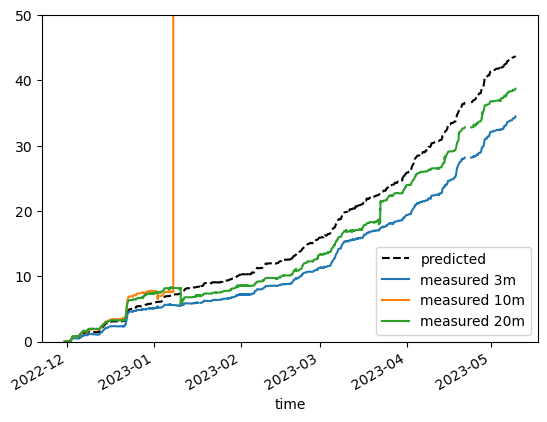

In [34]:
((sos_results_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted', color='black', linestyle='--'
)
(sos_inputs_df['w_h2o__3m_c'].loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'measured 3m'
)
(sos_inputs_df['w_h2o__10m_c'].loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'measured 10m'
)
(sos_inputs_df['w_h2o__20m_c'].loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'measured 20m'
)
plt.legend()
plt.ylim(0,50)

(-0.05, 0.05)

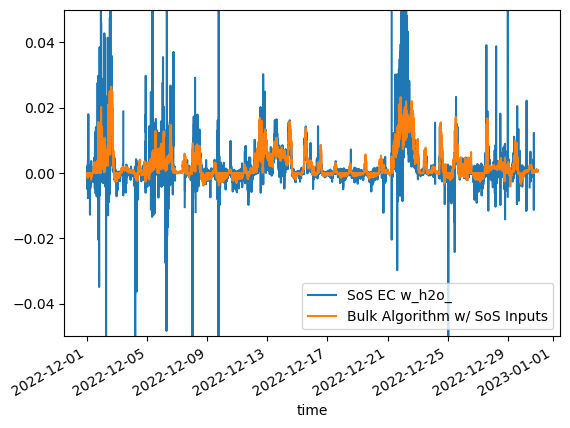

In [15]:
sos_inputs_df['w_h2o__3m_c'].loc['20221201': '20221230'].plot(label = 'SoS EC w_h2o_')
(sos_results_df['hlb_gperm2s']).loc['20221201': '20221230'].plot(label = 'Bulk Algorithm w/ SoS Inputs')
plt.legend()
plt.ylim(-0.05, 0.05)

(-0.05, 0.05)

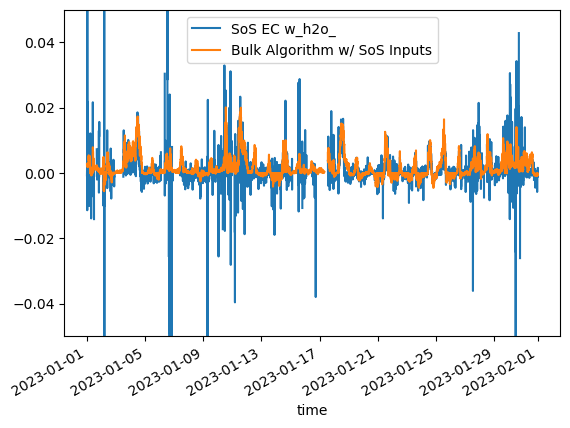

In [16]:
sos_inputs_df['w_h2o__3m_c'].loc['20230101': '20230131'].plot(label = 'SoS EC w_h2o_')
(sos_results_df['hlb_gperm2s']).loc['20230101': '20230131'].plot(label = 'Bulk Algorithm w/ SoS Inputs')
plt.legend()
plt.ylim(-0.05, 0.05)

# SPLASH Run

## Load SPLASH data

In [35]:
splash_data_vars = [
    'snow_depth',
    'skin_temp_surface',
    'wspd_vec_mean',
    'temp',
    'mixing_ratio',
    'atmos_pressure',
    'Hl',
    'bulk_Hl'
]

In [36]:
# for comparison with SOS data in december
splash_files_dec22 = glob.glob(
    "/storage/elilouis/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb**202212**.nc"
)

splash_files_all = glob.glob(
    "/storage/elilouis/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb**.nc"
)

# winter 2021-2022 
splash_files_winter_21_22 = [ v for v in splash_files_all if v >=
 '/storage/elilouis/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb.asfs30.level2.0.10min.20211101.000000.nc'
 and 
 v <
 '/storage/elilouis/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/sledseb.asfs30.level2.0.10min.20220601.000000.nc'
]

In [37]:
splash_inputs_dec22_ds = xr.open_mfdataset(splash_files_dec22, 
                                     compat='override',
                                     coords=['time'],
                                     preprocess=lambda ds: ds[splash_data_vars]
                                    )

In [38]:
splash_inputs_winter_21_22_ds = xr.open_mfdataset(splash_files_winter_21_22, 
                                     compat='override',
                                     coords=['time'],
                                     preprocess=lambda ds: ds[splash_data_vars]
                                    )

In [39]:
splash_inputs_dec22_df = splash_inputs_dec22_ds.to_dataframe()
splash_inputs_winter_21_22_df = splash_inputs_winter_21_22_ds.to_dataframe()

In [40]:
splash_inputs_dec22_df = utils.modify_df_timezone(splash_inputs_dec22_df.reset_index(), pytz.UTC, pytz.timezone("US/Mountain")).set_index('time')
# fill missing snow depth values, which there are a lot of, these the backfill method
# splash_inputs_dec22_df.snow_depth = splash_inputs_dec22_df.snow_depth.interpolate(method='bfill')
# convert snow depth from cm to m
splash_inputs_dec22_df.snow_depth = splash_inputs_dec22_df.snow_depth/100
# convert mixing ratio from g/kg to g/g which is the same as kg/kg
splash_inputs_dec22_df.mixing_ratio = splash_inputs_dec22_df.mixing_ratio/1000


splash_inputs_winter_21_22_df = utils.modify_df_timezone(splash_inputs_winter_21_22_df.reset_index(), pytz.UTC, pytz.timezone("US/Mountain")).set_index('time')
# fill missing snow depth values, which there are a lot of, these the backfill method
# splash_inputs_winter_21_22_df.snow_depth = splash_inputs_winter_21_22_df.snow_depth.interpolate(method='bfill')
# convert snow depth from cm to m
splash_inputs_winter_21_22_df.snow_depth = splash_inputs_winter_21_22_df.snow_depth/100
# convert mixing ratio from g/kg to g/g which is the same as kg/kg
splash_inputs_winter_21_22_df.mixing_ratio = splash_inputs_winter_21_22_df.mixing_ratio/1000

In [41]:
SPLASH_ANEMOMETER_HEIGHT = 4.62
SPLASH_THERMOMETER_HEIGHT = 2.89
SPLASH_HYGROMETER_HEIGHT = 2.8
INVERSION_HEIGHT = 600

In [42]:
splash_results_dec22_list = []
for time, row in splash_inputs_dec22_df.iterrows():
    bulk_inputs = [
        row['wspd_vec_mean'],
        row['skin_temp_surface'],
        row['temp'],
        row['mixing_ratio'],
        INVERSION_HEIGHT,
        row['atmos_pressure'],
        SPLASH_ANEMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_THERMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_HYGROMETER_HEIGHT - row['snow_depth']
    ]
    try:
        bulk_outputs = functions_library.cor_ice_A10(bulk_inputs)
        splash_results_dec22_list.append(bulk_outputs)
    except:
        print(f"Failed on timestamp: {time}")
        splash_results_dec22_list.append(np.full(len(output_var_names), np.nan))

splash_results_dec22_df = pd.DataFrame(splash_results_dec22_list)
splash_results_dec22_df.columns = output_var_names
splash_results_dec22_df = splash_results_dec22_df
splash_results_dec22_df.index = splash_inputs_dec22_df.index

Failed on timestamp: 2022-11-30 17:00:00
Failed on timestamp: 2022-11-30 17:10:00
Failed on timestamp: 2022-11-30 17:20:00
Failed on timestamp: 2022-11-30 17:30:00
Failed on timestamp: 2022-11-30 17:40:00
Failed on timestamp: 2022-11-30 17:50:00
Failed on timestamp: 2022-11-30 18:00:00
Failed on timestamp: 2022-11-30 18:10:00
Failed on timestamp: 2022-11-30 18:20:00
Failed on timestamp: 2022-11-30 18:30:00
Failed on timestamp: 2022-11-30 18:40:00
Failed on timestamp: 2022-11-30 18:50:00
Failed on timestamp: 2022-11-30 19:00:00
Failed on timestamp: 2022-11-30 19:10:00
Failed on timestamp: 2022-11-30 19:20:00
Failed on timestamp: 2022-11-30 19:30:00
Failed on timestamp: 2022-11-30 19:40:00
Failed on timestamp: 2022-11-30 19:50:00
Failed on timestamp: 2022-11-30 20:00:00
Failed on timestamp: 2022-11-30 20:10:00
Failed on timestamp: 2022-11-30 20:20:00
Failed on timestamp: 2022-11-30 20:30:00
Failed on timestamp: 2022-11-30 20:40:00
Failed on timestamp: 2022-11-30 20:50:00
Failed on timest

In [43]:
splash_results_winter_21_22_list = []
for time, row in splash_inputs_winter_21_22_df.iterrows():
    bulk_inputs = [
        row['wspd_vec_mean'],
        row['skin_temp_surface'],
        row['temp'],
        row['mixing_ratio'],
        INVERSION_HEIGHT,
        row['atmos_pressure'],
        SPLASH_ANEMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_THERMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_HYGROMETER_HEIGHT - row['snow_depth']
    ]
    try:
        bulk_outputs = functions_library.cor_ice_A10(bulk_inputs)
        splash_results_winter_21_22_list.append(bulk_outputs)
    except:
        print(f"Failed on timestamp: {time}")
        splash_results_winter_21_22_list.append(np.full(len(output_var_names), np.nan))

splash_results_winter_21_22_df = pd.DataFrame(splash_results_winter_21_22_list)
splash_results_winter_21_22_df.columns = output_var_names
splash_results_winter_21_22_df = splash_results_winter_21_22_df
splash_results_winter_21_22_df.index = splash_inputs_winter_21_22_df.index

Failed on timestamp: 2021-10-31 18:00:00
Failed on timestamp: 2021-10-31 18:10:00
Failed on timestamp: 2021-10-31 18:20:00
Failed on timestamp: 2021-10-31 18:30:00
Failed on timestamp: 2021-10-31 18:40:00
Failed on timestamp: 2021-10-31 18:50:00
Failed on timestamp: 2021-10-31 19:00:00
Failed on timestamp: 2021-10-31 19:10:00
Failed on timestamp: 2021-10-31 19:20:00
Failed on timestamp: 2021-10-31 19:30:00
Failed on timestamp: 2021-10-31 19:40:00
Failed on timestamp: 2021-10-31 19:50:00
Failed on timestamp: 2021-10-31 20:00:00
Failed on timestamp: 2021-10-31 20:10:00
Failed on timestamp: 2021-10-31 20:20:00
Failed on timestamp: 2021-10-31 20:30:00
Failed on timestamp: 2021-10-31 20:40:00
Failed on timestamp: 2021-10-31 20:50:00
Failed on timestamp: 2021-10-31 21:00:00
Failed on timestamp: 2021-10-31 21:10:00
Failed on timestamp: 2021-10-31 21:20:00
Failed on timestamp: 2021-10-31 21:30:00
Failed on timestamp: 2021-10-31 21:40:00
Failed on timestamp: 2021-10-31 21:50:00
Failed on timest

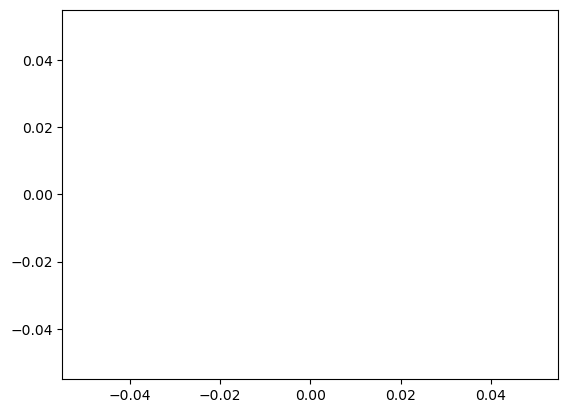

In [44]:
plt.scatter(
    splash_inputs_winter_21_22_df['bulk_Hl'],
    splash_results_winter_21_22_df['hlb']
)

# Calculate mixing ratio gradients for SoS and SPLASH data

In [45]:
# These are copied from data-processing/functions_librarymath
sos_es=(1.0003+4.18e-6*sos_inputs_df['P_10m_c'])*6.1115*np.exp(22.452*sos_inputs_df['Tsurf_c']/(sos_inputs_df['Tsurf_c']+272.55))
sos_inputs_df['surface_mixing_ratio'] = sos_es*622/(1010.0-.378*sos_es)/1000    
sos_inputs_df['mixingratio_diff'] = sos_inputs_df['mixingratio_3m_c'] - sos_inputs_df['surface_mixing_ratio']

splash_es=(1.0003+4.18e-6*splash_inputs_winter_21_22_df['atmos_pressure'])*6.1115*np.exp(22.452*splash_inputs_winter_21_22_df['skin_temp_surface']/(splash_inputs_winter_21_22_df['skin_temp_surface']+272.55))
splash_inputs_winter_21_22_df['surface_mixing_ratio'] = splash_es*622/(1010.0-.378*splash_es)/1000    
splash_inputs_winter_21_22_df['mixingratio_diff'] = splash_inputs_winter_21_22_df['mixing_ratio'] - splash_inputs_winter_21_22_df['surface_mixing_ratio']

splash_es=(1.0003+4.18e-6*splash_inputs_dec22_df['atmos_pressure'])*6.1115*np.exp(22.452*splash_inputs_dec22_df['skin_temp_surface']/(splash_inputs_dec22_df['skin_temp_surface']+272.55))
splash_inputs_dec22_df['surface_mixing_ratio'] = splash_es*622/(1010.0-.378*splash_es)/1000    
splash_inputs_dec22_df['mixingratio_diff'] = splash_inputs_dec22_df['mixing_ratio'] - splash_inputs_dec22_df['surface_mixing_ratio']

# Plot results


In [46]:
seconds_per_10min = 10*60

Text(0, 0.5, 'Cumulative latent heat fluxes (mm)')

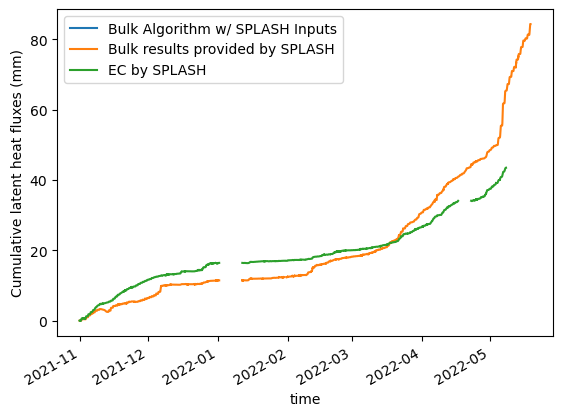

In [47]:
(
    (splash_results_winter_21_22_df['hlb']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk Algorithm w/ SPLASH Inputs')
(
    (splash_inputs_winter_21_22_df['bulk_Hl']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk results provided by SPLASH')
(
    (splash_inputs_winter_21_22_df['Hl']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='EC by SPLASH')
plt.legend()
plt.ylabel("Cumulative latent heat fluxes (mm)")

Text(0, 0.5, 'Mixing ratio gradient (3m - surface)')

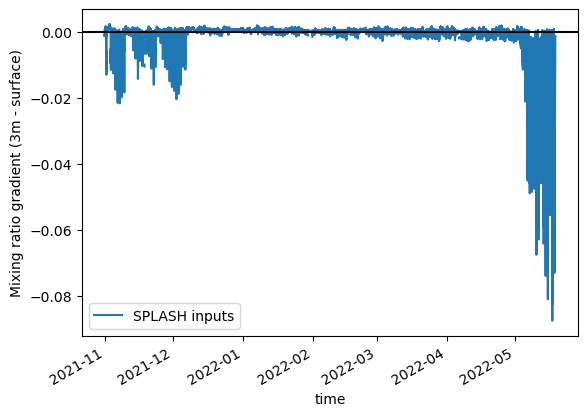

In [48]:
(splash_inputs_winter_21_22_df['mixingratio_diff']).plot(label='SPLASH inputs')
plt.axhline(0, color='black', zorder=10)
plt.legend()
plt.ylabel("Mixing ratio gradient (3m - surface)")

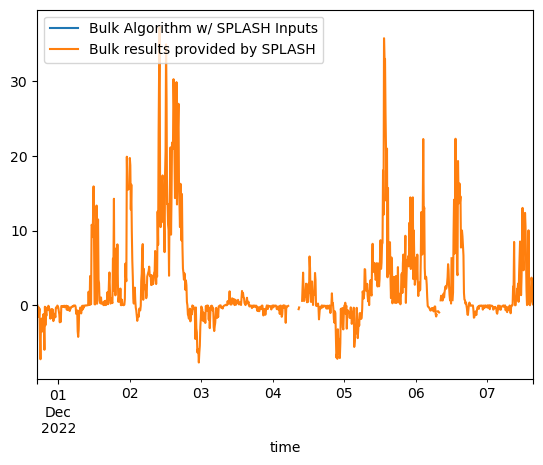

In [49]:
(splash_results_dec22_df['hlb']).head(1000).plot(label='Bulk Algorithm w/ SPLASH Inputs')
(splash_inputs_dec22_df['bulk_Hl']).head(1000).plot(label='Bulk results provided by SPLASH')
plt.legend()

Text(0, 0.5, 'Cumulative latent heat fluxes (mm)')

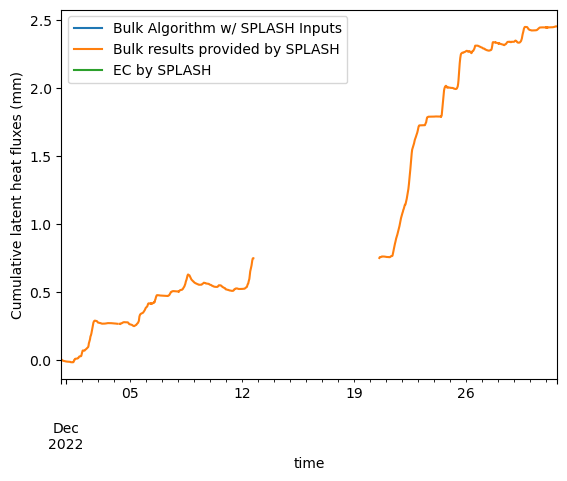

In [50]:
(
    (splash_results_dec22_df['hlb']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk Algorithm w/ SPLASH Inputs')
(
    (splash_inputs_dec22_df['bulk_Hl']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk results provided by SPLASH')
(
    (splash_inputs_dec22_df['Hl']).cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='EC by SPLASH')
plt.legend()
plt.ylabel("Cumulative latent heat fluxes (mm)")

Text(0, 0.5, 'Mixing ratio gradient (3m - surface)')

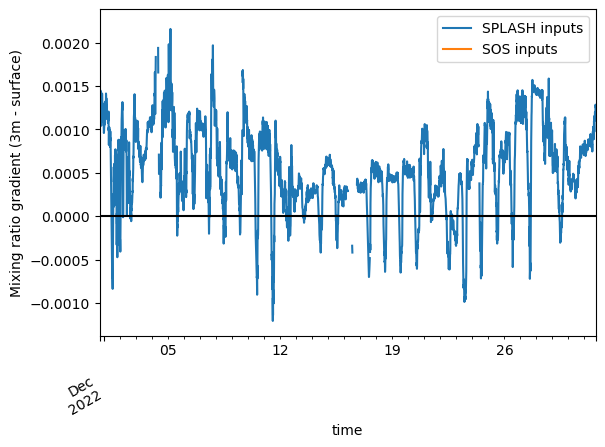

In [51]:
(splash_inputs_dec22_df['mixingratio_diff']).plot(label='SPLASH inputs')
(sos_inputs_df['mixingratio_diff'].loc['20221201': '20221231']).plot(label='SOS inputs')
plt.axhline(0, color='black', zorder=10)
plt.legend()
plt.ylabel("Mixing ratio gradient (3m - surface)")

## Compare SPLASH and SOS measurements/inputs

Text(0, 0.5, 'Snow depth (m)')

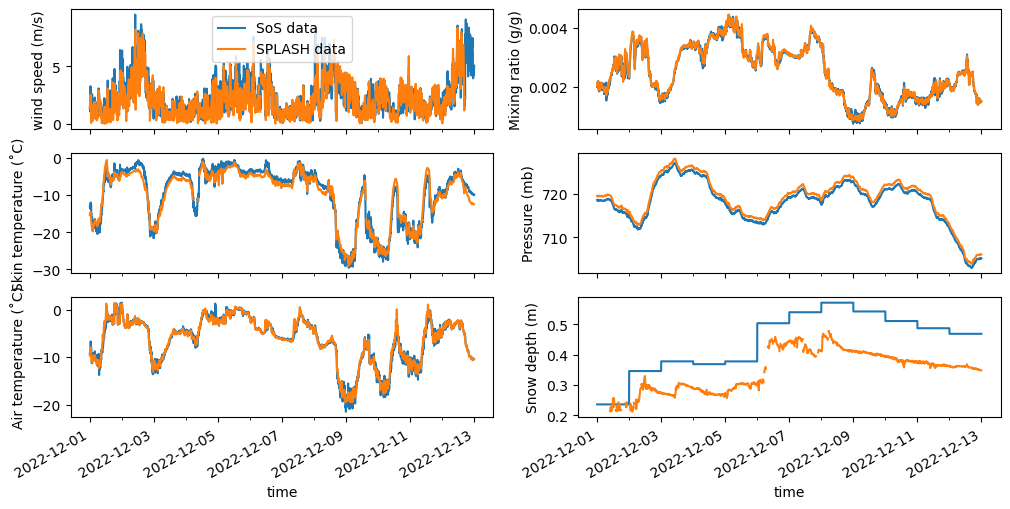

<Figure size 600x300 with 0 Axes>

In [52]:
fig, axes = plt.subplots(3, 2, figsize = (12, 6), sharex=True)
plt.figure(figsize=(6,3))

sos_inputs_df['spd_3m_c'].loc['20221201': '20221212'].plot(ax=axes[0,0], label='SoS data')
splash_inputs_dec22_df['wspd_vec_mean'].loc['20221201': '20221212'].plot(ax=axes[0,0], label='SPLASH data')
axes[0,0].set_ylabel("wind speed (m/s)")
axes[0,0].legend()

sos_inputs_df['Tsurf_c'].loc['20221201': '20221212'].plot(ax=axes[1,0])
splash_inputs_dec22_df['skin_temp_surface'].loc['20221201': '20221212'].plot(ax=axes[1,0])
axes[1,0].set_ylabel("Skin temperature (˚C)")

sos_inputs_df['T_3m_c'].loc['20221201': '20221212'].plot(ax=axes[2,0])
splash_inputs_dec22_df['temp'].loc['20221201': '20221212'].plot(ax=axes[2,0])
axes[2,0].set_ylabel("Air temperature (˚C)")

sos_inputs_df['mixingratio_3m_c'].loc['20221201': '20221212'].plot(ax=axes[0,1])
splash_inputs_dec22_df['mixing_ratio'].loc['20221201': '20221212'].plot(ax=axes[0,1])
axes[0,1].set_ylabel("Mixing ratio (g/g)")

sos_inputs_df['P_10m_c'].loc['20221201': '20221212'].plot(ax=axes[1,1])
splash_inputs_dec22_df['atmos_pressure'].loc['20221201': '20221212'].plot(ax=axes[1,1])
axes[1,1].set_ylabel("Pressure (mb)")

sos_inputs_df['SnowDepth_d'].loc['20221201': '20221212'].plot(ax=axes[2,1])
splash_inputs_dec22_df['snow_depth'].loc['20221201': '20221212'].plot(ax=axes[2,1])
axes[2,1].set_ylabel("Snow depth (m)")


Text(0, 0.5, 'Cumulative latent heat fluxes (w/m^2)')

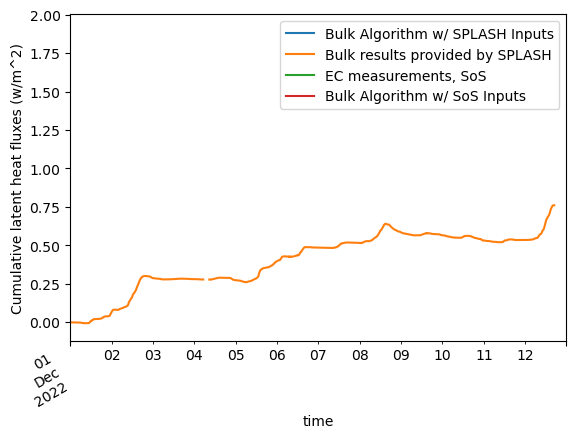

In [53]:
(
    (splash_results_dec22_df['hlb']).loc['20221201': '20221212'].cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk Algorithm w/ SPLASH Inputs')
(
    (splash_inputs_dec22_df['bulk_Hl']).loc['20221201': '20221212'].cumsum()*seconds_per_10min/density_water/latent_heat_of_vaporization
).plot(label='Bulk results provided by SPLASH')
(
    (sos_inputs_df['w_h2o__3m_c']).loc['20221201': '20221212'].cumsum()*seconds_in_sos_timestep/density_water
).plot(label='EC measurements, SoS', linestyle='-')
(
    (sos_results_df['hlb']).loc['20221201': '20221212'].cumsum()*seconds_in_sos_timestep/density_water/latent_heat_of_vaporization
).plot(label='Bulk Algorithm w/ SoS Inputs')
plt.legend()
plt.ylabel("Cumulative latent heat fluxes (w/m^2)")

Text(0, 0.5, 'Mixing ratio gradient (3m - surface)')

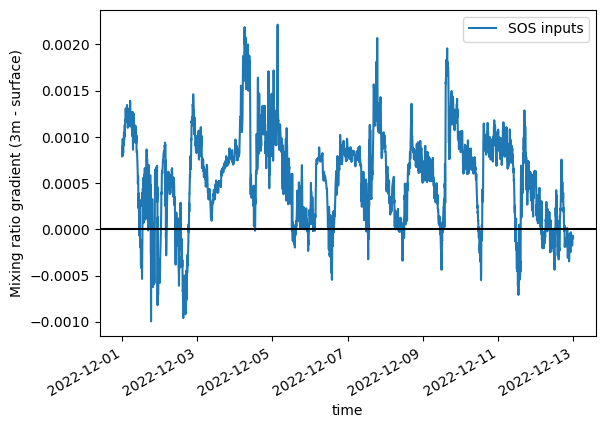

In [54]:
(sos_inputs_df['mixingratio_diff'].loc['20221201': '20221212']).plot(label='SOS inputs')
plt.axhline(0, color='black', zorder=10)
plt.legend()
plt.ylabel("Mixing ratio gradient (3m - surface)")

Text(0.5, 0, 'Mixing ratio gradient (3m - surface)')

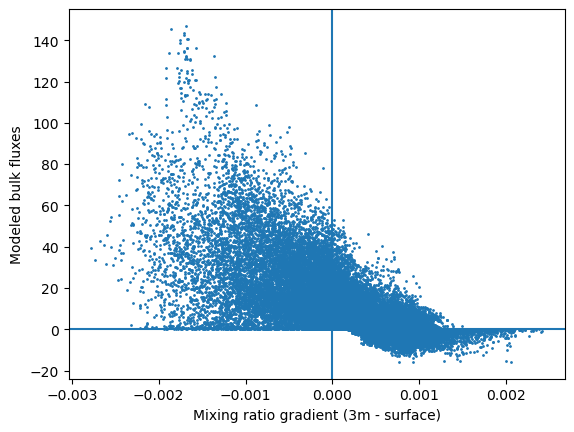

In [55]:
plt.scatter(
    sos_inputs_df['mixingratio_diff'],
    sos_results_df['hlb'],
    s= 1
) 
plt.axhline(0)
plt.axvline(0)
plt.ylabel("Modeled bulk fluxes")
plt.xlabel("Mixing ratio gradient (3m - surface)")

Text(0.5, 0, 'Mixing ratio gradient (3m - surface)')

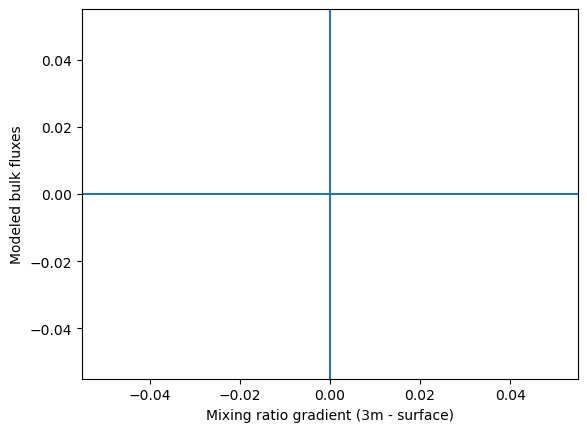

In [56]:
plt.scatter(
    splash_inputs_dec22_df['mixingratio_diff'],
    splash_results_dec22_df['hlb'],
    s= 1
) 
plt.axhline(0)
plt.axvline(0)
plt.ylabel("Modeled bulk fluxes")
plt.xlabel("Mixing ratio gradient (3m - surface)")